In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [3]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [4]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [5]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index
w_cat_ids['y'] = w_cat_ids.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_day'].transform('sum').clip(0,20)
w_cat_ids = w_cat_ids.drop_duplicates(['date_block_num', 'item_id', 'shop_id'])

In [6]:
w_cat_ids['item_mean'] = w_cat_ids.groupby(['item_id'])['y'].transform('mean')
w_cat_ids['item_mean_month'] = w_cat_ids.groupby(['item_id', 'month'])['y'].transform('mean')
w_cat_ids['item_mean_month_year'] = w_cat_ids.groupby(['item_id', 'month', 'year'])['y'].transform('mean')

In [7]:
def quarter(month):
    if month in [1,2,3]:
        return 1
    if month in [4,5,6]:
        return 2
    if month in [7,8,9]:
        return 3
    if month in [10,11,12]:
        return 4
    
w_cat_ids['quarter'] = w_cat_ids['month'].apply(quarter)

In [8]:
w_cat_ids['quarter_mean'] = w_cat_ids.groupby(['item_id', 'quarter'])['y'].transform('mean')
w_cat_ids['quarter_mean_year'] = w_cat_ids.groupby(['item_id', 'quarter', 'year'])['y'].transform('mean')

In [9]:
lag_2014 = w_cat_ids[(w_cat_ids.year == 2014)].drop_duplicates(['item_id', 'month', 'year'])[['item_id','item_mean_month_year','month']]\
                                   .copy().rename(columns={'item_mean_month_year':'item_mean_month_year_minus_1'})


w_cat_ids_2015 = w_cat_ids[(w_cat_ids.year == 2015)].copy()
w_cat_ids_2015 = pd.merge(w_cat_ids_2015, lag_2014, on=['item_id', 'month'], how='left')

lag_2013 = w_cat_ids[(w_cat_ids.year == 2013)].drop_duplicates(['item_id', 'month', 'year'])[['item_id','item_mean_month_year','month']]\
                                   .copy().rename(columns={'item_mean_month_year':'item_mean_month_year_minus_1'})


w_cat_ids_2014 = w_cat_ids[(w_cat_ids.year == 2014)].copy()
w_cat_ids_2014 = pd.merge(w_cat_ids_2014, lag_2013, on=['item_id', 'month'], how='left')

w_cat_ids_2013 = w_cat_ids[(w_cat_ids.year == 2013)].copy()
w_cat_ids_2013['item_mean_month_year_minus_1'] = np.nan


frames = [w_cat_ids_2013, w_cat_ids_2014, w_cat_ids_2015]

X = pd.concat(frames,sort=False)



In [10]:
lag_2014 = X[(X.year == 2014)].drop_duplicates(['item_id', 'quarter', 'year'])[['item_id','quarter_mean_year','quarter']]\
                                   .copy().rename(columns={'quarter_mean_year':'quarter_mean_year_minus_1'})


w_cat_ids_2015 = X[(X.year == 2015)].copy()
w_cat_ids_2015 = pd.merge(w_cat_ids_2015, lag_2014, on=['item_id', 'quarter'], how='left')

lag_2013 = X[(X.year == 2013)].drop_duplicates(['item_id', 'quarter', 'year'])[['item_id','quarter_mean_year','quarter']]\
                                   .copy().rename(columns={'quarter_mean_year':'quarter_mean_year_minus_1'})


w_cat_ids_2014 = X[(X.year == 2014)].copy()
w_cat_ids_2014 = pd.merge(w_cat_ids_2014, lag_2013, on=['item_id', 'quarter'], how='left')

w_cat_ids_2013 = X[(X.year == 2013)].copy()
w_cat_ids_2013['quarter_mean_year_minus_1'] = np.nan


frames = [w_cat_ids_2013, w_cat_ids_2014, w_cat_ids_2015]

X = pd.concat(frames,sort=False)



In [16]:
X['date_block_num'].unique()

array([ 1,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 20, 15, 18, 19, 21,
       22, 23, 12, 14, 16, 17, 13, 24, 27, 25, 26, 28, 29, 30, 31, 32, 33])

In [52]:
rollings = X[['item_mean_month_year', 'date_block_num', 'item_id']].copy()
rollings = rollings.drop_duplicates(['item_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num'])
a = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month_year'].rolling(3).mean()
a

item_id  date_block_num
0        20                     NaN
1        15                     NaN
         18                     NaN
         19                1.333333
         20                1.000000
         21                1.000000
2        19                     NaN
         22                     NaN
3        18                     NaN
         19                     NaN
4        20                     NaN
5        23                     NaN
6        18                     NaN
7        23                     NaN
8        19                     NaN
         20                     NaN
9        19                     NaN
10       24                     NaN
11       22                     NaN
12       1                      NaN
13       20                     NaN
14       23                     NaN
15       22                     NaN
16       20                     NaN
17       20                     NaN
18       19                     NaN
19       0                      NaN
20  

In [22]:
a.index

KeyboardInterrupt: 

In [56]:
b = pd.DataFrame(a)
#b.index[0][0]
#b.index[0]

#b.columns
#b.index[2]
#b = b.reset_index(level=[0,1])
#b.rename(columns={'item_id': 'dummy'}, inplace=True)
b.rename(columns={'item_mean_month_year': 'rolling_item_mean_month_year'}, inplace=True)

#b = b.reset_index()
#b['item_id']

#b.columns
b
X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [58]:
X[X['item_id'] == 30].drop_duplicates(['item_id', 'date_block_num'])[['item_id', 'month', 'year', 'item_mean_month_year', 'item_mean_month_year_minus_1','quarter_mean_year','quarter', 'quarter_mean_year_minus_1',\
                                                                    'rolling_item_mean_month_year']]

,item_id,month,year,item_mean_month_year,item_mean_month_year_minus_1,quarter_mean_year,quarter,quarter_mean_year_minus_1,rolling_item_mean_month_year
121,30,2,2013,12.733333,NaN,10.840909,1,NaN,NaN
166,30,3,2013,8.860465,NaN,10.840909,1,NaN,NaN
209,30,4,2013,3.823529,NaN,3.225352,2,NaN,8.472443
243,30,5,2013,2.500000,NaN,3.225352,2,NaN,5.061332
263,30,6,2013,2.882353,NaN,3.225352,2,NaN,3.068627
280,30,7,2013,1.782609,NaN,1.520833,3,NaN,2.388321
303,30,8,2013,1.266667,NaN,1.520833,3,NaN,1.977209
318,30,9,2013,1.300000,NaN,1.520833,3,NaN,1.449758
328,30,10,2013,1.090909,NaN,1.746269,4,NaN,1.219192
350,30,11,2013,2.000000,NaN,1.746269,4,NaN,1.463636


In [60]:
X.columns

Index(['item_id', 'date', 'date_block_num', 'shop_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'item_name', 'item_category_id',
       'row_id', 'y', 'item_mean', 'item_mean_month', 'item_mean_month_year',
       'quarter', 'quarter_mean', 'quarter_mean_year',
       'item_mean_month_year_minus_1', 'quarter_mean_year_minus_1',
       'rolling_item_mean_month_year'],
      dtype='object')

In [116]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [73]:
features = ['item_id', 'date_block_num', 'shop_id', #'item_price',
        'month', 'year', 'item_category_id',
       'item_mean', 'item_mean_month',# 'item_mean_month_year',
       'quarter', 'quarter_mean', 'quarter_mean_year',
       'item_mean_month_year_minus_1', 'quarter_mean_year_minus_1',
       'rolling_item_mean_month_year']

In [63]:
# categories test
cat_counts_test = pd.DataFrame(test_w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts_test['percentage'] = cat_counts_test['counts'] * 100 / cat_counts_test.counts.sum()

# categories train
cat_counts = pd.DataFrame(w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts['percentage'] = cat_counts['counts'] * 100 / cat_counts.counts.sum()

combined  = pd.merge(cat_counts, cat_counts_test,  how='left', left_on=['item_category_id'], right_on = ['item_category_id'])
combined = combined.rename(index= str, columns={"counts_x": "total_train", "percentage_x": "%train", "counts_y": "total_test", "percentage_y": "%test"})

shares = {}
for _, row in combined.iterrows():
    shares[row['item_category_id']] = row['%test']

no_nans = [v for v in shares.values() if not np.isnan(v)] 
#sorted(no_nans, reverse=True)

val_len = 25000

    
def get_share_of_group(group):
    #print(type(group))
    cat_id = np.unique(group[['item_category_id']])[0]
    share = shares[cat_id]

    #print(share)
    needed = val_len * share / 100
    #print(needed)

    if len(group) <= needed:
        print("Needed %d but only %d available for cat_id %d with share %f" % (needed, len(group), cat_id, share))
    #else:
        #print("OK")
    if np.isnan(needed):
        return group.head(0)
    return group.head(int(needed))


#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group).index
val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group)['row_id'].values

Needed 39 but only 18 available for cat_id 9 with share 0.156863
Needed 9 but only 4 available for cat_id 26 with share 0.039216
Needed 4 but only 1 available for cat_id 27 with share 0.019608
Needed 1357 but only 563 available for cat_id 31 with share 5.431373
Needed 24 but only 10 available for cat_id 34 with share 0.098039
Needed 9 but only 7 available for cat_id 36 with share 0.039216
Needed 357 but only 332 available for cat_id 43 with share 1.431373
Needed 171 but only 133 available for cat_id 45 with share 0.686275
Needed 186 but only 83 available for cat_id 54 with share 0.745098
Needed 1093 but only 727 available for cat_id 58 with share 4.372549
Needed 39 but only 29 available for cat_id 60 with share 0.156863
Needed 132 but only 123 available for cat_id 62 with share 0.529412
Needed 4 but only 4 available for cat_id 74 with share 0.019608
Needed 299 but only 109 available for cat_id 76 with share 1.196078
Needed 78 but only 63 available for cat_id 77 with share 0.313725
Need

In [75]:
X[features].head()

,item_id,date_block_num,shop_id,month,year,item_category_id,item_mean,item_mean_month,quarter,quarter_mean,quarter_mean_year,item_mean_month_year_minus_1,quarter_mean_year_minus_1,rolling_item_mean_month_year
0,12,1,54,2,2013,55,1.0,1.0,1,1.0,1.0,NaN,NaN,NaN
1,19,0,25,1,2013,40,1.0,1.0,1,1.0,1.0,NaN,NaN,NaN
2,27,0,19,1,2013,19,1.0,1.0,1,1.0,1.0,NaN,NaN,NaN
3,27,0,26,1,2013,19,1.0,1.0,1,1.0,1.0,NaN,NaN,NaN
4,27,0,2,1,2013,19,1.0,1.0,1,1.0,1.0,NaN,NaN,NaN


In [76]:
x = X[features] 
y = X['y']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [77]:
lgtrain = lgbm.Dataset(x_train, label=y_train, categorical_feature=[0,1,2,3,4,5])
lgval = lgbm.Dataset(x_val, label=y_val, categorical_feature=[0,1,2,3,4,5])



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        "learning_rate" : 0.05
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.36796
[200]	valid_0's rmse: 1.32495
[300]	valid_0's rmse: 1.30652
[400]	valid_0's rmse: 1.29886
[500]	valid_0's rmse: 1.29123
[600]	valid_0's rmse: 1.28626
[700]	valid_0's rmse: 1.2814
[800]	valid_0's rmse: 1.27859
[900]	valid_0's rmse: 1.27508
[1000]	valid_0's rmse: 1.27329
[1100]	valid_0's rmse: 1.27254
[1200]	valid_0's rmse: 1.27108
[1300]	valid_0's rmse: 1.26953
[1400]	valid_0's rmse: 1.26842
[1500]	valid_0's rmse: 1.26791
[1600]	valid_0's rmse: 1.26405
[1700]	valid_0's rmse: 1.26237
[1800]	valid_0's rmse: 1.2615
[1900]	valid_0's rmse: 1.26019
[2000]	valid_0's rmse: 1.25723
[2100]	valid_0's rmse: 1.25584
[2200]	valid_0's rmse: 1.25527
[2300]	valid_0's rmse: 1.25506
[2400]	valid_0's rmse: 1.25404
[2500]	valid_0's rmse: 1.25383
[2600]	valid_0's rmse: 1.25272
[2700]	valid_0's rmse: 1.25202
[2800]	valid_0's rmse: 1.25154
[2900]	valid_0's rmse: 1.25049
[3000]	valid_0's rmse: 1.24974
[3100]	valid_0's r

In [117]:
test_w_cat_ids['date_block_num'] = 34
test_w_cat_ids['month'] = 11
test_w_cat_ids['year'] = 2015
test_w_cat_ids['quarter'] = 4

In [101]:
item_level = X.drop_duplicates(['item_id'])[['item_id','item_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_level, on=['item_id'], how='left')

In [102]:
item_month_level = X[(X.month == 11)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [103]:
item_quarter_level = X[(X.quarter == 4)].drop_duplicates(['item_id'])[['item_id','quarter_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_quarter_level, on=['item_id'], how='left')

In [104]:
item_quarter_year_level = X[(X.quarter == 4) & (X.year == 2015)].drop_duplicates(['item_id'])[['item_id','quarter_mean_year']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_quarter_year_level, on=['item_id'], how='left')

In [105]:
item_month_level_ = X[(X.month == 11) & (X.year == 2014)].drop_duplicates(['item_id'])[['item_id','item_mean_month', 'quarter_mean_year']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_year_minus_1', 'quarter_mean_year': 'quarter_mean_year_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [107]:
item_month_level_ = X[(X.month == 10) & (X.year == 2015)].drop_duplicates(['item_id'])[['item_id','rolling_item_mean_month_year']].copy()


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [109]:
test_w_cat_ids[features].head()b

,item_id,date_block_num,shop_id,month,year,item_category_id,item_mean,item_mean_month,quarter,quarter_mean,quarter_mean_year,item_mean_month_year_minus_1,quarter_mean_year_minus_1,rolling_item_mean_month_year
0,30,34,5,11,2015,40,3.473029,1.787879,4,1.666667,1.0,1.787879,1.5,1.0
1,30,34,4,11,2015,40,3.473029,1.787879,4,1.666667,1.0,1.787879,1.5,1.0
2,30,34,6,11,2015,40,3.473029,1.787879,4,1.666667,1.0,1.787879,1.5,1.0
3,30,34,3,11,2015,40,3.473029,1.787879,4,1.666667,1.0,1.787879,1.5,1.0
4,30,34,2,11,2015,40,3.473029,1.787879,4,1.666667,1.0,1.787879,1.5,1.0


In [114]:
test_w_cat_ids['item_mean_month'] = test_w_cat_ids['item_mean_month'].fillna(test_w_cat_ids['quarter_mean_year'])
test_w_cat_ids['item_mean_month'] = test_w_cat_ids['item_mean_month'].fillna(test_w_cat_ids['quarter_mean_year'])

In [115]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
date_block_num,date_block_num,0.000000
month,month,0.000000
year,year,0.000000
quarter,quarter,0.000000
item_mean,item_mean,7.117647


In [112]:
preds = np.clip(model_lgb.predict(test_w_cat_ids[features]), 0,20)

In [113]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


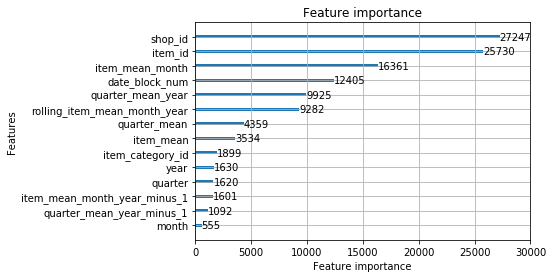

In [111]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit